# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

In [68]:
import warnings
warnings.filterwarnings('ignore')

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [10]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.946514981501345

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [12]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.280515438982047

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [37]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [38]:
#1
x = np.random.exponential(size=sample_size)

In [39]:
#2
y = f(x) + np.random.uniform(low=-1.,high=1.,size=sample_size)

In [16]:
#3
from sklearn.tree import DecisionTreeRegressor

In [40]:
print(x.shape,y.shape,linspace.shape)

(100,) (100,) (1000,)


In [41]:
x = x[:, np.newaxis]
y = y[:, np.newaxis]
linspace = linspace[:, np.newaxis]
tree = DecisionTreeRegressor(random_state=42)
predictions = tree.fit(x,y).predict(linspace)

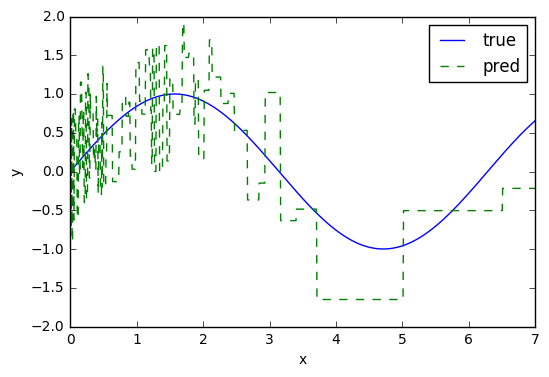

In [45]:
#4
plt.plot(linspace, f(linspace),linestyle='-',color='blue',label='true')
plt.plot(linspace,predictions,linestyle='--',color='green',label='pred')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

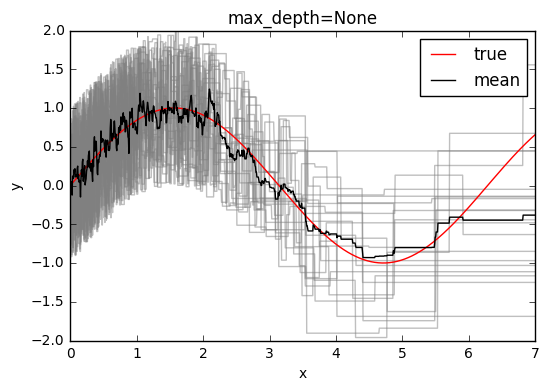

In [57]:
#1-3 for 20 samples
def mygraph(depth):
    pred=0
    for sample in range(samples_num):
        x = np.random.exponential(size=sample_size)
        y = f(x) + np.random.uniform(low=-1.,high=1.,size=sample_size)
        linspace = np.linspace(0, 7, 1000) 
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]
        linspace = linspace[:, np.newaxis]
        tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
        predictions = tree.fit(x,y).predict(linspace)
        pred += predictions
        plt.plot(linspace, predictions,linestyle='-',color="gray", alpha=0.5)
    mean_pred = pred / samples_num
    plt.plot(linspace, f(linspace),linestyle='-',color='red',label='true')
    plt.plot(linspace,mean_pred,linestyle='-',color='black',label='mean')
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('max_depth='+str(depth))
    plt.show()
mygraph(None)

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

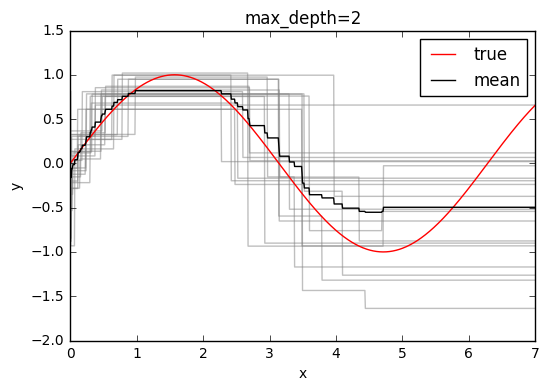

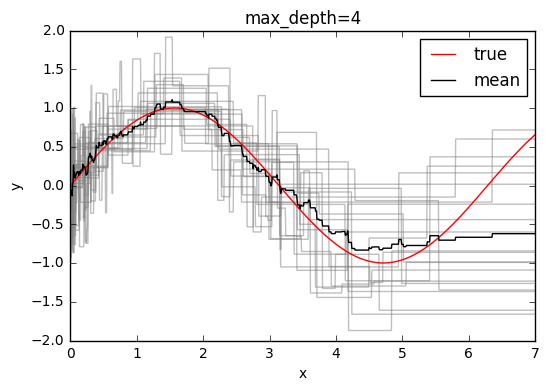

In [58]:
mygraph(2)
mygraph(4)

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Исходя из проведенного эксперимента можно сказать, что увеличение глубины решающего дерева снижает смещение алгоритма $E_{p(x)}\left( E_{p(y|x)}y - E_{X}\mu \right)^2$ (т.е. насколько обученный по всем выборкам и усредненный алгоритм отклоняется от идеального): видно, что линия (черная) среднего алгоритма меньше всего отклоняется от линии (красная) идеального алгоритма для случая дерева с глубиной 4 (В случае без ограничения на глубину дерева наблюдается большое смещение при $x \in (0;2)$. В случае  дерева с глубиной 2 наблюдается большое смещение при $x \in (3;5.8)$). Как результат, можно утверждать, что смещение решающего дерева близко к нулю для дерева с глубиной 4.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [59]:
from sklearn.linear_model import LinearRegression

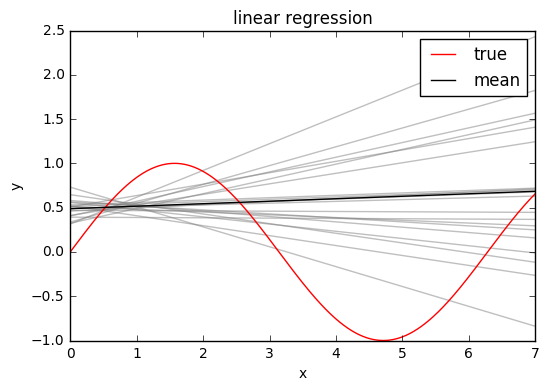

In [63]:
# linear regression
#1-3 for 20 samples
pred=0
for sample in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1.,high=1.,size=sample_size)
    linspace = np.linspace(0, 7, 1000) 
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]
    linspace = linspace[:, np.newaxis]
    linreg = LinearRegression()
    predictions = linreg.fit(x,y).predict(linspace)
    pred += predictions
    plt.plot(linspace, predictions,linestyle='-',color="gray", alpha=0.5)
mean_pred = pred / samples_num
plt.plot(linspace, f(linspace),linestyle='-',color='red',label='true')
plt.plot(linspace,mean_pred,linestyle='-',color='black',label='mean')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression')
plt.show()

**Вывод:** из полученного графика видно, что восстановленная по обучающим выборкам линейная регрессия обладает огромным смещением: черная линия (среднего алгоритма) совсем непохожа на красную (идеального). Результат вполне естественный: линейная регрессия это очень простой алгоритм, смещение которых, как правило, очень большое. Посмотрим теперь на SVM:

In [64]:
from sklearn.svm import SVR

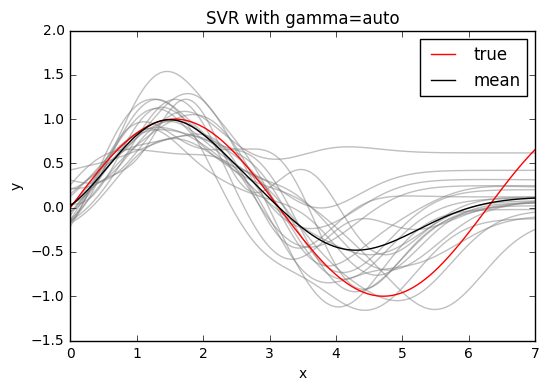

In [70]:
#1-3 for 20 samples
def svr(gamma):
    pred=0
    for sample in range(samples_num):
        x = np.random.exponential(size=sample_size)
        y = f(x) + np.random.uniform(low=-1.,high=1.,size=sample_size)
        linspace = np.linspace(0, 7, 1000) 
        x = x[:, np.newaxis]
        y = y[:, np.newaxis]
        linspace = linspace[:, np.newaxis]
        support = SVR(gamma=gamma)
        predictions = support.fit(x,y).predict(linspace)
        pred += predictions
        plt.plot(linspace, predictions,linestyle='-',color="gray", alpha=0.5)
    mean_pred = pred / samples_num
    plt.plot(linspace, f(linspace),linestyle='-',color='red',label='true')
    plt.plot(linspace,mean_pred,linestyle='-',color='black',label='mean')
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('SVR with gamma='+str(gamma))
    plt.show()
svr('auto')

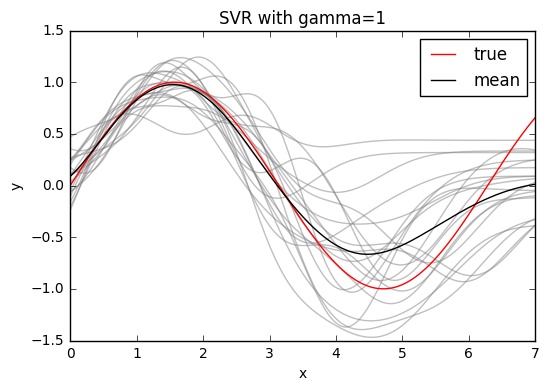

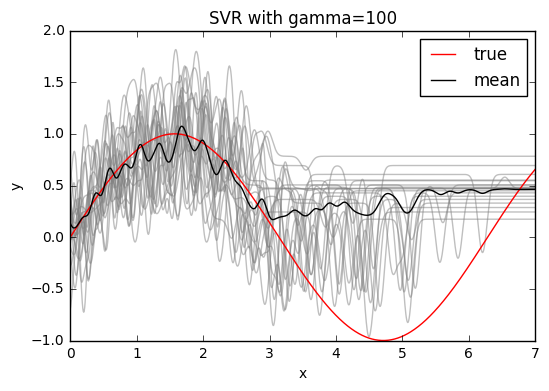

In [71]:
svr(1)
svr(100)

**Вывод:** из графиков выше видно, что наименьшим смещением обладает SVR с параметром qamma=1:  SVR с параметром gamma=auto обладает большим смещением (отклонение черной линии от красной) на промежутке $x \in (3;6)$,  SVR с параметром gamma=100 обладает ещё большим смещением на промежутке $x \in (3;6)$ (и к тому же характеризуется огромным разбросом). Поэтому в данном случае нельзя сказать, что с более сложным алгоритмом мы получаем меньшее смещение, а SVR с параметром gamma=auto в данном случае оптимальный вариант с точки зрения смещения.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [73]:
import pandas as pd

In [124]:
# upload data
url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
url2 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
url3 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
url4 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
mushrooms = pd.read_csv(url1,header=None)
tictac = pd.read_csv(url2,header=None)
car = pd.read_csv(url3,header=None)
nursery = pd.read_csv(url4,header=None)

Все признаки вещественные:

In [101]:
# code categorical data
from sklearn.preprocessing import LabelEncoder 

In [127]:
mushrooms = mushrooms.apply(LabelEncoder().fit_transform)
#mushrooms[0] = LabelEncoder().fit_transform(list(mushrooms[0]))

In [128]:
tictac = tictac.apply(LabelEncoder().fit_transform)

In [131]:
car.iloc[:,0:6] = car.iloc[:,0:6].apply(LabelEncoder().fit_transform)

In [133]:
car[6] = np.where((car[6] == 'unacc') | (car[6] == 'acc'),0,1)

In [135]:
nursery.iloc[:,0:8] = nursery.iloc[:,0:8].apply(LabelEncoder().fit_transform)

In [136]:
nursery[8] = np.where((nursery[8]=='recommend')|(nursery[8]=='not_recom'),0,1)

In [138]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [144]:
tree_num = DecisionTreeClassifier()
print("mushrooms:",np.mean(cross_val_score(tree_num, mushrooms.iloc[:,1:], mushrooms[0],cv=10,
                                   scoring=make_scorer(accuracy_score))))
print('tictac:', np.mean(cross_val_score(tree_num, tictac.iloc[:,:9], tictac[9],cv=10,
                                   scoring=make_scorer(accuracy_score))))
print('cars:', np.mean(cross_val_score(tree_num, car.iloc[:,:6], car[6],cv=10,
                                   scoring=make_scorer(accuracy_score))))
print('nursery:', np.mean(cross_val_score(tree_num, nursery.iloc[:,:8], nursery[8],cv=10,
                                   scoring=make_scorer(accuracy_score))))

mushrooms: 0.958154101886
tictac: 0.735804508048
cars: 0.94097166533
nursery: 0.999691477008


Все признаки категориальные:

In [152]:
mushrooms = pd.read_csv(url1,header=None)
tictac = pd.read_csv(url2,header=None)
car = pd.read_csv(url3,header=None)
nursery = pd.read_csv(url4,header=None)

In [153]:
mushrooms[0] = LabelEncoder().fit_transform(list(mushrooms[0]))
mushrooms1 = pd.concat([pd.get_dummies(mushrooms.iloc[:,1:]),mushrooms[0]],axis=1)

In [155]:
tictac[9] = LabelEncoder().fit_transform(list(tictac[9]))
tictac1 = pd.concat([pd.get_dummies(tictac.iloc[:,:9]),tictac[9]],axis=1)

In [157]:
car[6] = np.where((car[6] == 'unacc') | (car[6] == 'acc'),0,1)
car1 = pd.concat([pd.get_dummies(car.iloc[:,:6]),car[6]],axis=1)

In [159]:
nursery[8] = np.where((nursery[8]=='recommend')|(nursery[8]=='not_recom'),0,1)
nursery1 = pd.concat([pd.get_dummies(nursery.iloc[:,:8]),nursery[8]],axis=1)

In [164]:
tree_num = DecisionTreeClassifier()
print("mushrooms:",np.mean(cross_val_score(tree_num, mushrooms1.iloc[:,:-1], mushrooms1.iloc[:,-1],
                                           cv=10,scoring=make_scorer(accuracy_score))))
print('tictac:', np.mean(cross_val_score(tree_num, tictac1.iloc[:,:-1], tictac1.iloc[:,-1],
                                         cv=10,scoring=make_scorer(accuracy_score))))
print('cars:', np.mean(cross_val_score(tree_num, car1.iloc[:,:-1], car1.iloc[:,-1],
                                       cv=10,scoring=make_scorer(accuracy_score))))
print('nursery:', np.mean(cross_val_score(tree_num, nursery1.iloc[:,:-1], nursery1.iloc[:,-1],
                                          cv=10,scoring=make_scorer(accuracy_score))))

mushrooms: 0.968265682657
tictac: 0.812360056068
cars: 0.824024325047
nursery: 0.999691477008


Корректное разбиение на категориальные и вещественные признаки:

In [187]:
mushrooms.head(2)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,x,s,n,t,p,f,c,1,k,...,s,w,w,p,w,1,p,k,s,u
1,0,x,s,y,t,a,f,c,0,k,...,s,w,w,p,w,1,p,n,n,g


Из описания признаков: признаки ring-number (one,two,none) и  gill-size(narrow,broad) - вещественные

In [167]:
print(mushrooms[18].unique(),mushrooms[8].unique())

['o' 't' 'n'] ['n' 'b']


In [181]:
mushrooms2 = mushrooms
mushrooms2[18] = LabelEncoder().fit_transform(list(mushrooms2[18]))
mushrooms2[8] = LabelEncoder().fit_transform(list(mushrooms[8]))
mushrooms3 = mushrooms2.drop([0,8,18],axis=1)
mushrooms4=pd.concat([pd.get_dummies(mushrooms3),mushrooms2[8],mushrooms2[18],mushrooms2[0]],axis=1)

In [186]:
mushrooms4.head(2)

,1_b,1_c,1_f,1_k,1_s,1_x,2_f,2_g,2_s,2_y,...,22_d,22_g,22_l,22_m,22_p,22_u,22_w,8,18,0
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,1,1
1,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [185]:
tictac.head(2)

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,1
1,x,x,x,x,o,o,o,x,o,1


все 9 признаков датасета tictac отвечают за крестик или нолик в ячейке таблицы игры 3х3, поэтому все признаки являются категориальными, следовательно, разумное разбиение повторяет предыдущее резбиение -- когда мы все признаки считаем категориальными.

In [188]:
car.head(2)

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,0
1,vhigh,vhigh,2,2,small,med,0


все признаки датасета car (buying, maint, doors, persons, lug_boot, safety) являются ординальными, то есть имеют отношение "больше-меньше" между значениями признака, поэтому разумно будет все признаки воспринимать как вещественные, что повторяет первое разбиение. 

In [189]:
car.iloc[:,0:6] = car.iloc[:,0:6].apply(LabelEncoder().fit_transform)

In [192]:
nursery.head(2)

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,0
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,1


все признаки датасета nursery (parents, has_nurs, form, children, housing, finance, social, health) можно воспринимать как ординальные, то есть имеющие отношение "больше-меньше" между значениями признака, поэтому разумно будет все признаки воспринимать как вещественные, что повторяет первое разбиение. 

In [193]:
nursery.iloc[:,0:8] = nursery.iloc[:,0:8].apply(LabelEncoder().fit_transform)

In [195]:
tree_num = DecisionTreeClassifier()
print("mushrooms:",np.mean(cross_val_score(tree_num, mushrooms4.iloc[:,:-1], mushrooms4.iloc[:,-1],
                                           cv=10,scoring=make_scorer(accuracy_score))))
print('tictac:', np.mean(cross_val_score(tree_num, tictac1.iloc[:,:-1], tictac1.iloc[:,-1],
                                         cv=10,scoring=make_scorer(accuracy_score))))
print('cars:', np.mean(cross_val_score(tree_num, car.iloc[:,:-1], car.iloc[:,-1],
                                       cv=10,scoring=make_scorer(accuracy_score))))
print('nursery:', np.mean(cross_val_score(tree_num, nursery.iloc[:,:-1], nursery.iloc[:,-1],
                                          cv=10,scoring=make_scorer(accuracy_score))))

mushrooms: 0.968265682657
tictac: 0.825035042503
cars: 0.94097166533
nursery: 0.999691477008


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Если вывести значения accuracy для каждого из 10 разбиений по каждому датасету, можно увидеть, что значения accuracy в некоторых фолдах сильно хуже, чем в остальных. Это значит, что в такой фолд могли попасть сильно различающиеся наблюдения от тех, на которых обучался алгоритм, что снизило значение accuracy:

In [281]:
print('mushrooms:', cross_val_score(tree_num, mushrooms4.iloc[:,:-1], mushrooms4.iloc[:,-1],
                                           cv=10,scoring=make_scorer(accuracy_score)))

mushrooms: [ 0.68511685  1.          1.          1.          0.99753998  1.          1.
  1.          1.          1.        ]


In [282]:
print('tictac:', cross_val_score(tree_num, tictac1.iloc[:,:-1], tictac1.iloc[:,-1],
                                         cv=10,scoring=make_scorer(accuracy_score)))

tictac: [ 0.70103093  0.90721649  0.42708333  0.94791667  0.86458333  0.77083333
  0.87368421  0.77894737  0.95789474  0.86315789]


In [283]:
print('cars:', cross_val_score(tree_num, car.iloc[:,:-1], car.iloc[:,-1],
                                       cv=10,scoring=make_scorer(accuracy_score)))

cars: [ 0.91954023  0.94827586  0.92528736  0.97126437  0.97093023  0.98837209
  0.91860465  0.88372093  0.93023256  0.95348837]


In [284]:
print('nursery:', cross_val_score(tree_num, nursery.iloc[:,:-1], nursery.iloc[:,-1],
                                          cv=10,scoring=make_scorer(accuracy_score)))

nursery: [ 0.99845798  1.          0.99845679  1.          1.          1.          1.
  1.          1.          1.        ]


Поэтому попробуем использовать другую технику кросс-валидации -- ShuffleSplit, которая на каждой из 10 итераций будет рандомно дробить всю выборку на train и test (в итоге получим 10 разбиений и значений accuracy): 

In [286]:
from sklearn.model_selection import ShuffleSplit

In [287]:
ss = ShuffleSplit(10)

In [289]:
print('mushrooms:', cross_val_score(tree_num, mushrooms4.iloc[:,:-1], mushrooms4.iloc[:,-1],
                                           cv=ss,scoring=make_scorer(accuracy_score)))

mushrooms: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [290]:
print('tictac:', cross_val_score(tree_num, tictac1.iloc[:,:-1], tictac1.iloc[:,-1],
                                         cv=ss,scoring=make_scorer(accuracy_score)))

tictac: [ 0.94791667  0.9375      0.90625     0.97916667  0.96875     0.96875
  0.94791667  0.91666667  0.97916667  0.88541667]


In [291]:
print('cars:', cross_val_score(tree_num, car.iloc[:,:-1], car.iloc[:,-1],
                                       cv=ss,scoring=make_scorer(accuracy_score)))

cars: [ 1.          0.98843931  1.          1.          0.97109827  1.
  0.98843931  0.99421965  0.98843931  0.99421965]


In [292]:
print('nursery:', cross_val_score(tree_num, nursery.iloc[:,:-1], nursery.iloc[:,-1],
                                          cv=ss,scoring=make_scorer(accuracy_score)))

nursery: [ 0.9992284   0.99691358  1.          1.          1.          1.          0.9992284
  1.          0.9992284   0.9992284 ]


Видим, что качество на каждом фолде выровнялось и увеличилось.

**Вывод:**
- Для разных наборов алгоритмы ранжируются по-разному. Когда делаем "умное" разбиение, оно почти для всех датасетов повторяет либо вещественное, либо категориальное разбиение, но в целом по 4 датасетам качество получается самым лучшим. Это происходит из-за устройства признаков данных -- являются ли признаки ординальными или нет (если не являются, кодировать как категориальные; если является, то можно кодировать как вещественные). Так, умное разбиение улучшает работу алгоритма для датасета tictac, для cars и nursery повторяет качество при вещественном разбиении, для mushrooms повторяет качество при категориальном разбиении.
- При использовании обычной KFold кросс-валидации в некоторые train и test выборки попадали сильно разные объекты, что ухудшало качество. При использовании более рандомизированной техники ShuffleSplitCV мы смогли устранить эту проблему. 
- В датасете tictac представлены все возможные комбинации крестиков и ноликов с учетом пустых клеток - по сути представлена вся генеральная совокупность с фиксированными ответами (тк правила игры всегда одинаковые). Поэтому в данном случае, когда мы обучаем алгоритм на 90% данных (на кросс-валидации с cv=10), мы намеренно ухудшаем, а не улучшаем алгоритм, ведь можно ему сразу показать все возможные комбинации признаков и ответов и получать идеальный прогноз. В данном случае наш алгоритм может просто запоминать ответы, но это и не страшно, ведь мы рассматриваем вообще все возможные исходы, которых не так много, убирая любую случайность:

In [269]:
a = np.arange(0,len(tictac),1)

In [270]:
# генерируем случайно "тестовую выборку"
test_sample = np.random.choice(a, size=300, replace=False)

In [272]:
# обучаем решающее дерево на полной выборке
sas = DecisionTreeClassifier().fit(tictac1.iloc[:,:-1], tictac1.iloc[:,-1])
preds = sas.predict(tictac1.iloc[test_sample,:-1])
# качество предсказаний
accuracy_score(tictac1.iloc[test_sample,-1], preds)

1.0

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [273]:
#1
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')

In [274]:
df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [201]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [203]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [275]:
tree = DecisionTreeClassifier(random_state=50)
bag = BaggingClassifier(n_estimators=100,random_state=50)
bagh = BaggingClassifier(n_estimators=100,max_features=0.5,random_state=50)
rf = RandomForestClassifier(n_estimators=100,random_state=50)

print('DecisionTree: ',np.mean(cross_val_score(tree, df.iloc[:,:-1], df.iloc[:,-1],
                                         cv=3,scoring=make_scorer(accuracy_score))))
print('Bagging: ',np.mean(cross_val_score(bag, df.iloc[:,:-1], df.iloc[:,-1],
                                         cv=3,scoring=make_scorer(accuracy_score))))
print('Bagging with half features: ',np.mean(cross_val_score(bagh, df.iloc[:,:-1], df.iloc[:,-1],
                                         cv=3,scoring=make_scorer(accuracy_score))))
print('RandomForest: ',np.mean(cross_val_score(rf, df.iloc[:,:-1], df.iloc[:,-1],
                                         cv=3,scoring=make_scorer(accuracy_score))))

DecisionTree:  0.462191722406
Bagging:  0.561039464192
Bagging with half features:  0.556055110962
RandomForest:  0.556696937645


В целом можно утверждать, что значение качества растет с каждым следующим алгоритмом (немного падает на бэггинге с половиной признаков, однако это зашумленное значение - можно взять меньше cv, чтобы выборка стала больше)

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [213]:
from sklearn.model_selection import train_test_split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], 
                                                    test_size=0.3, random_state=42)

In [221]:
quality_list=[]
forest = RandomForestClassifier(n_estimators=100,random_state=42,warm_start=True)
for trees in np.arange(200,5101,100):
    forest.fit(X_train,y_train)
    pred = forest.predict(X_test)
    quality = accuracy_score(y_test,pred)
    quality_list.append(quality)
    forest.set_params(n_estimators=trees)

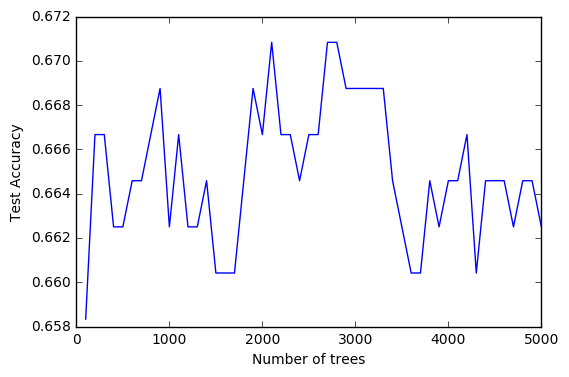

In [224]:
plt.plot(np.arange(100,5001,100), quality_list)
plt.xlabel('Number of trees')
plt.ylabel('Test Accuracy')

**Вывод:** по графику видно, что качество на тестовой выборке для случайного леса остается почти постоянным (меняется в пределах 0.01, что не является значительным отклонением и может быть связано с округлением accuracy_score), то есть с ростом числа деревьев алгоритм не переобучается. Это является логичным, ведь каждое дерево обучается независимо от других на разных случайных подвыборках, и предсказания затем усредняются ("деревья голосуют").

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [225]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [245]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [234]:
num_pixels = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

In [236]:
# normalize from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

In [237]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [239]:
# create model with 100 neurons in hidden layers
model = Sequential()
model.add(Dense(100, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [241]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
6s - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0816 - val_acc: 0.9754
Epoch 2/10
1s - loss: 0.0280 - acc: 0.9915 - val_loss: 0.0810 - val_acc: 0.9753
Epoch 3/10
2s - loss: 0.0236 - acc: 0.9931 - val_loss: 0.0764 - val_acc: 0.9765
Epoch 4/10
3s - loss: 0.0194 - acc: 0.9944 - val_loss: 0.0804 - val_acc: 0.9779
Epoch 5/10
4s - loss: 0.0180 - acc: 0.9947 - val_loss: 0.0853 - val_acc: 0.9766
Epoch 6/10
4s - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0853 - val_acc: 0.9771
Epoch 7/10
3s - loss: 0.0139 - acc: 0.9959 - val_loss: 0.0866 - val_acc: 0.9751
Epoch 8/10
4s - loss: 0.0110 - acc: 0.9968 - val_loss: 0.0911 - val_acc: 0.9762
Epoch 9/10
3s - loss: 0.0095 - acc: 0.9976 - val_loss: 0.0910 - val_acc: 0.9759
Epoch 10/10
3s - loss: 0.0108 - acc: 0.9967 - val_loss: 0.0934 - val_acc: 0.9756
Error: 2.44%


На тесте удается добиться качества (accuracy) выше 97%, что уже неплохо. Попробуем улучшить сеть.

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [256]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28).astype('float32')

In [257]:
# normalize inputs from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [258]:
# add Dropout to the model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [259]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
325s - loss: 0.2190 - acc: 0.9370 - val_loss: 0.0697 - val_acc: 0.9766
Epoch 2/10
530s - loss: 0.0636 - acc: 0.9812 - val_loss: 0.0463 - val_acc: 0.9846
Epoch 3/10
517s - loss: 0.0426 - acc: 0.9875 - val_loss: 0.0422 - val_acc: 0.9848
Epoch 4/10
458s - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0358 - val_acc: 0.9883
Epoch 5/10
343s - loss: 0.0243 - acc: 0.9924 - val_loss: 0.0354 - val_acc: 0.9887
Epoch 6/10
327s - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0471 - val_acc: 0.9861
Epoch 7/10
338s - loss: 0.0144 - acc: 0.9957 - val_loss: 0.0324 - val_acc: 0.9897
Epoch 8/10
357s - loss: 0.0118 - acc: 0.9966 - val_loss: 0.0331 - val_acc: 0.9892
Epoch 9/10
339s - loss: 0.0080 - acc: 0.9980 - val_loss: 0.0355 - val_acc: 0.9890
Epoch 10/10
325s - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0316 - val_acc: 0.9912
Error: 0.88%


**Вывод:** на тестовой выборке получили accuracy = 99.12%, что можно считать успешным выполнением задания

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [262]:
# add Dropout to the model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [263]:
# Fit the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
237s - loss: 0.2214 - acc: 0.9359 - val_loss: 0.0664 - val_acc: 0.9798
Epoch 2/10
279s - loss: 0.0667 - acc: 0.9800 - val_loss: 0.0444 - val_acc: 0.9846
Epoch 3/10
339s - loss: 0.0469 - acc: 0.9854 - val_loss: 0.0478 - val_acc: 0.9833
Epoch 4/10
340s - loss: 0.0357 - acc: 0.9889 - val_loss: 0.0418 - val_acc: 0.9859
Epoch 5/10
345s - loss: 0.0260 - acc: 0.9923 - val_loss: 0.0338 - val_acc: 0.9894
Epoch 6/10
369s - loss: 0.0237 - acc: 0.9922 - val_loss: 0.0281 - val_acc: 0.9902
Epoch 7/10
434s - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0306 - val_acc: 0.9899
Epoch 8/10
419s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.0293 - val_acc: 0.9897
Epoch 9/10
450s - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0303 - val_acc: 0.9903
Epoch 10/10
432s - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0287 - val_acc: 0.9914
Error: 0.86%


Добавление Dropot-слоя означает исключение из сети нейронов с вероятностью $p$ (вероятность выключения каждого нейрона одинакова), в нашем случае $p=0.2$. Исключение нейрона означает, что на любых входных данных или параметрах нейрон возвращает 0 и не вносит свой вклад в процесс обучения ни на одном из этапов обратного распространения ошибки, что рвносильно обучению новой нейронной сети. Таким образом, нейроны учатся "подменять" друг друга, что предотвращает взаимоадаптацию нейронов на этапе обучения и проблему переобучения. В нашем случае добавление Dropout- слоя улучшило качество алгоритма на тестовой выборке, теперь accuracy составляет 99.14%, что на 0.02% предыдущего результата.  

[Открытый источник с нейронными сетями](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)